<a href="https://colab.research.google.com/github/Niki-KR/TMO/blob/master/notebooks/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторная работа №3. Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

# Разведочный анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/dc-wikia-data.csv")

In [3]:
# Типы признаков
df.dtypes

page_id               int64
name                 object
urlslug              object
ID                   object
ALIGN                object
EYE                  object
HAIR                 object
SEX                  object
GSM                  object
ALIVE                object
APPEARANCES         float64
FIRST APPEARANCE     object
YEAR                float64
dtype: object

In [4]:
# Размерность датасета
df.shape

(6896, 13)

Все признаки, за исключением `APPEARANCES`, `YEAR` и `page_id` являются категориальаными.

In [5]:
# Проверка на пропуски в данных
df.isnull().sum()

page_id                0
name                   0
urlslug                0
ID                  2013
ALIGN                601
EYE                 3628
HAIR                2274
SEX                  125
GSM                 6832
ALIVE                  3
APPEARANCES          355
FIRST APPEARANCE      69
YEAR                  69
dtype: int64

# Обработка пропусков

Для категориального признака `GSM` значения отсутсвуют почти во всех записях! Признак следует удалить из датасета целиком за его ненадобностью.

In [6]:
# Удаление признака GSM
df1 = df.drop(labels="GSM", axis=1)
df1.isnull().sum()

page_id                0
name                   0
urlslug                0
ID                  2013
ALIGN                601
EYE                 3628
HAIR                2274
SEX                  125
ALIVE                  3
APPEARANCES          355
FIRST APPEARANCE      69
YEAR                  69
dtype: int64

Пропуски в категориальном признаке `ALIGN` заменим константным значением `Unknown`.

In [0]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')
# Замена исходного столбца на столбец с импутированными пропусками
df1['ALIGN'] = imp.fit_transform(df1[['ALIGN']])

Для количественного признака `Year` (отсутвующих значений - 1%) сгенерируем описательную статистику, а также построим `boxplot`, чтобы подобрать наиболее подходящую стратегию обработки пропусков.

In [8]:
df1['YEAR'].describe()

count    6827.000000
mean     1989.766662
std        16.824194
min      1935.000000
25%      1983.000000
50%      1992.000000
75%      2003.000000
max      2013.000000
Name: YEAR, dtype: float64

In [9]:
df1['YEAR'].value_counts()

2006.0    303
1988.0    286
2010.0    279
1989.0    266
1987.0    254
         ... 
1952.0      5
1937.0      4
1935.0      1
1953.0      1
2013.0      1
Name: YEAR, Length: 79, dtype: int64

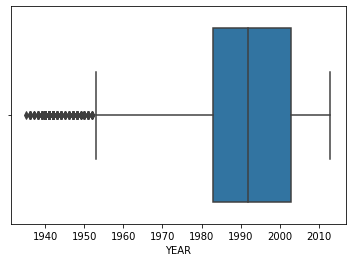

In [10]:
sns.boxplot(x=df1['YEAR'])

Половина всех значений признака лежит на отрезке [1983, 2003]. Медиана признака `YEAR` равна 1992.

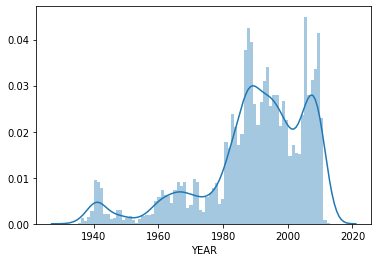

In [11]:
sns.distplot(df1['YEAR'], bins=79)

Заполним пропуски медаинным значением.

In [0]:
# Медиана
med = df1['YEAR'].median()

In [13]:
df1['YEAR'].tail()

6891   NaN
6892   NaN
6893   NaN
6894   NaN
6895   NaN
Name: YEAR, dtype: float64

In [14]:
# Заполнение пропусков
df1['YEAR'] = df1['YEAR'].fillna(value=med)
df1['YEAR'].tail()

6891    1992.0
6892    1992.0
6893    1992.0
6894    1992.0
6895    1992.0
Name: YEAR, dtype: float64

In [0]:
med = df1['APPEARANCES'].median()
df1['APPEARANCES'] = df1['APPEARANCES'].fillna(value=med)

# Кодирование категориальных признаков

Определим количество всех возможных категорий для каждого признака.

In [16]:
# Количество категорий по признакам
df1.nunique()

page_id             6896
name                6896
urlslug             6896
ID                     3
ALIGN                  5
EYE                   17
HAIR                  17
SEX                    4
ALIVE                  2
APPEARANCES          282
FIRST APPEARANCE     774
YEAR                  79
dtype: int64

Для признака `ALIGN` определено всего пять категорий. Для его кодирования подойдёт метод **one-shot encoding**.

In [17]:
# Категории признака ALIGN
df1['ALIGN'].unique()

array(['Good Characters', 'Bad Characters', 'Neutral Characters',
       'Unknown', 'Reformed Criminals'], dtype=object)

In [18]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
enc_cat = df1[['ALIGN']]
enc_cat.shape

(6896, 1)

In [19]:
ohe_enc_cat = ohe.fit_transform(enc_cat)
df3 = pd.DataFrame(ohe_enc_cat.todense(), columns=df1['ALIGN'].unique())
df3

,Good Characters,Bad Characters,Neutral Characters,Unknown,Reformed Criminals
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
6891,0.0,1.0,0.0,0.0,0.0
6892,0.0,1.0,0.0,0.0,0.0
6893,0.0,1.0,0.0,0.0,0.0
6894,0.0,1.0,0.0,0.0,0.0


In [20]:
# Добавление новых признаков в датасет
df1 = df1.join(df3)
df1

,page_id,name,urlslug,ID,ALIGN,EYE,HAIR,SEX,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,Good Characters,Bad Characters,Neutral Characters,Unknown,Reformed Criminals
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,3093.0,"1939, May",1939.0,0.0,1.0,0.0,0.0,0.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,2496.0,"1986, October",1986.0,0.0,1.0,0.0,0.0,0.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Good Characters,Brown Eyes,Brown Hair,Male Characters,Living Characters,1565.0,"1959, October",1959.0,0.0,1.0,0.0,0.0,0.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Good Characters,Brown Eyes,White Hair,Male Characters,Living Characters,1316.0,"1987, February",1987.0,0.0,1.0,0.0,0.0,0.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Good Characters,Blue Eyes,Black Hair,Male Characters,Living Characters,1237.0,"1940, April",1940.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6891,66302,Nadine West (New Earth),\/wiki\/Nadine_West_(New_Earth),Public Identity,Good Characters,NaN,NaN,Female Characters,Living Characters,6.0,NaN,1992.0,0.0,1.0,0.0,0.0,0.0
6892,283475,Warren Harding (New Earth),\/wiki\/Warren_Harding_(New_Earth),Public Identity,Good Characters,NaN,NaN,Male Characters,Living Characters,6.0,NaN,1992.0,0.0,1.0,0.0,0.0,0.0
6893,283478,William Harrison (New Earth),\/wiki\/William_Harrison_(New_Earth),Public Identity,Good Characters,NaN,NaN,Male Characters,Living Characters,6.0,NaN,1992.0,0.0,1.0,0.0,0.0,0.0
6894,283471,William McKinley (New Earth),\/wiki\/William_McKinley_(New_Earth),Public Identity,Good Characters,NaN,NaN,Male Characters,Living Characters,6.0,NaN,1992.0,0.0,1.0,0.0,0.0,0.0


In [0]:
# Удаление признака ALIGN
del df1['ALIGN']

# Масштабирование данных


Масштабированию подлежит количественный признак `APPEARANCES`. Используем метод масштабирования по **Z-оценке**.

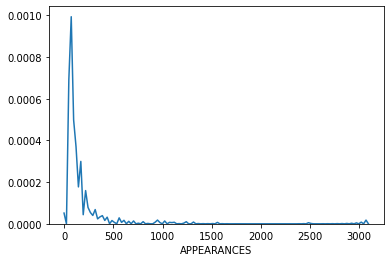

In [22]:
sns.distplot(df1['APPEARANCES'], hist=False, bins=100)

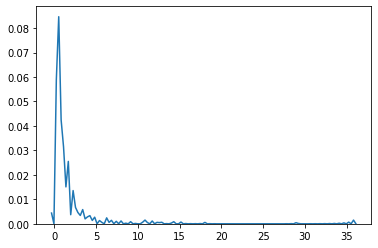

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df1[['APPEARANCES']])
sns.distplot(scaled_data, hist=False, bins=100)

In [24]:
df1['APPEARANCES'] = scaled_data
df1

,page_id,name,urlslug,ID,EYE,HAIR,SEX,ALIVE,APPEARANCES,FIRST APPEARANCE,YEAR,Good Characters,Bad Characters,Neutral Characters,Unknown,Reformed Criminals
0,1422,Batman (Bruce Wayne),\/wiki\/Batman_(Bruce_Wayne),Secret Identity,Blue Eyes,Black Hair,Male Characters,Living Characters,36.043670,"1939, May",1939.0,0.0,1.0,0.0,0.0,0.0
1,23387,Superman (Clark Kent),\/wiki\/Superman_(Clark_Kent),Secret Identity,Blue Eyes,Black Hair,Male Characters,Living Characters,29.035170,"1986, October",1986.0,0.0,1.0,0.0,0.0,0.0
2,1458,Green Lantern (Hal Jordan),\/wiki\/Green_Lantern_(Hal_Jordan),Secret Identity,Brown Eyes,Brown Hair,Male Characters,Living Characters,18.105668,"1959, October",1959.0,0.0,1.0,0.0,0.0,0.0
3,1659,James Gordon (New Earth),\/wiki\/James_Gordon_(New_Earth),Public Identity,Brown Eyes,White Hair,Male Characters,Living Characters,15.182525,"1987, February",1987.0,0.0,1.0,0.0,0.0,0.0
4,1576,Richard Grayson (New Earth),\/wiki\/Richard_Grayson_(New_Earth),Secret Identity,Blue Eyes,Black Hair,Male Characters,Living Characters,14.255102,"1940, April",1940.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6891,66302,Nadine West (New Earth),\/wiki\/Nadine_West_(New_Earth),Public Identity,NaN,NaN,Female Characters,Living Characters,-0.196259,NaN,1992.0,0.0,1.0,0.0,0.0,0.0
6892,283475,Warren Harding (New Earth),\/wiki\/Warren_Harding_(New_Earth),Public Identity,NaN,NaN,Male Characters,Living Characters,-0.196259,NaN,1992.0,0.0,1.0,0.0,0.0,0.0
6893,283478,William Harrison (New Earth),\/wiki\/William_Harrison_(New_Earth),Public Identity,NaN,NaN,Male Characters,Living Characters,-0.196259,NaN,1992.0,0.0,1.0,0.0,0.0,0.0
6894,283471,William McKinley (New Earth),\/wiki\/William_McKinley_(New_Earth),Public Identity,NaN,NaN,Male Characters,Living Characters,-0.196259,NaN,1992.0,0.0,1.0,0.0,0.0,0.0
